In [ ]:
import os
import requests
from bs4 import BeautifulSoup

# NASA Earthdata Login credentials
USERNAME = 'prasannadhungel123456789@gmail.com'
PASSWORD = 'prasannadhungel123456789@gmail.com'

# Months to download (June, July, August 2023)
MONTHS = ['06', '07', '08']

# Base directory for downloads
BASE_DOWNLOAD_DIR = './imerg_jun_aug_2023_tifs'
os.makedirs(BASE_DOWNLOAD_DIR, exist_ok=True)

# Start session with authentication
session = requests.Session()
session.auth = (USERNAME, PASSWORD)

# Loop through each month
for month in MONTHS:
    year_month = f'2023/{month}'
    full_month_code = f'2023{month}'
    BASE_URL = f'https://jsimpsonhttps.pps.eosdis.nasa.gov/imerg/gis/early/{year_month}/'
    MONTH_DOWNLOAD_DIR = os.path.join(BASE_DOWNLOAD_DIR, f'{full_month_code}')
    os.makedirs(MONTH_DOWNLOAD_DIR, exist_ok=True)

    print(f'\n Processing month: {full_month_code}')

    # Access the monthly page
    response = session.get(BASE_URL)
    if response.status_code != 200:
        print(f" Failed to access {BASE_URL}. Check credentials or NASA login.")
        continue

    soup = BeautifulSoup(response.text, 'html.parser')

    # Filter and download all 30min .tif files for the month
    for link in soup.find_all('a'):
        href = link.get('href')
        if href and href.endswith('30min.tif') and full_month_code in href:
            file_url = BASE_URL + href
            filename = os.path.join(MONTH_DOWNLOAD_DIR, href)
            if not os.path.exists(filename):  # Avoid re-downloading
                print(f'⬇ Downloading {href}...')
                file_resp = session.get(file_url)
                if file_resp.status_code == 200:
                    with open(filename, 'wb') as f:
                        f.write(file_resp.content)
                else:
                    print(f" Failed to download {href}")
            else:
                print(f"✔ Already exists: {href}")

print("\n Download complete for June–August 2023.")



 Processing month: 202306
⬇ Downloading 3B-HHR-E.MS.MRG.3IMERG.20230601-S000000-E002959.0000.V07B.30min.tif...
⬇ Downloading 3B-HHR-E.MS.MRG.3IMERG.20230601-S003000-E005959.0030.V07B.30min.tif...
⬇ Downloading 3B-HHR-E.MS.MRG.3IMERG.20230601-S010000-E012959.0060.V07B.30min.tif...
⬇ Downloading 3B-HHR-E.MS.MRG.3IMERG.20230601-S013000-E015959.0090.V07B.30min.tif...
⬇ Downloading 3B-HHR-E.MS.MRG.3IMERG.20230601-S020000-E022959.0120.V07B.30min.tif...
⬇ Downloading 3B-HHR-E.MS.MRG.3IMERG.20230601-S023000-E025959.0150.V07B.30min.tif...
⬇ Downloading 3B-HHR-E.MS.MRG.3IMERG.20230601-S030000-E032959.0180.V07B.30min.tif...
⬇ Downloading 3B-HHR-E.MS.MRG.3IMERG.20230601-S033000-E035959.0210.V07B.30min.tif...
⬇ Downloading 3B-HHR-E.MS.MRG.3IMERG.20230601-S040000-E042959.0240.V07B.30min.tif...
⬇ Downloading 3B-HHR-E.MS.MRG.3IMERG.20230601-S043000-E045959.0270.V07B.30min.tif...
⬇ Downloading 3B-HHR-E.MS.MRG.3IMERG.20230601-S050000-E052959.0300.V07B.30min.tif...
⬇ Downloading 3B-HHR-E.MS.MRG.3IMERG.2

In [ ]:
import shutil

# Zip the folder
shutil.make_archive('imerg_jun_aug_2023_tifs', 'zip', '/content/imerg_jun_aug_2023_tifs')

# Download the zip
from google.colab import files
files.download('imerg_jun_aug_2023_tifs.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install rasterio geopandas pandas numpy shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 86.5 MB/s eta 0:00:00


In [ ]:
import os
import glob
import re
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import pandas as pd
import numpy as np
from datetime import datetime
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

def parse_imerg_filename(filename):
    """Extract timestamp and resolution from IMERG filename, handling duplicates, and skip 1day/3hr."""
    try:
        pattern = r"3B-HHR-E\.MS\.MRG\.3IMERG\.(\d{8})-S(\d{6})-E\d{6}\.\d{4}\.V07B\.(30min|1day|3hr)\.tif(?:\(\d+\))?"
        match = re.match(pattern, os.path.basename(filename))
        if not match:
            print(f"Skipping invalid file: {filename}")
            return None
        date_str, time_str, resolution = match.groups()
        if resolution in ['1day', '3hr']:
            print(f"Skipping {filename} due to {resolution} resolution.")
            return None
        timestamp = datetime.strptime(f"{date_str}-{time_str}", "%Y%m%d-%H%M%S")
        return timestamp, resolution
    except Exception as e:
        print(f"Error parsing filename {filename}: {e}")
        return None

def load_bardiya_shapefile(shapefile_path):
    """Load and filter Bardiya district from GADM level-3 shapefile."""
    try:
        gdf = gpd.read_file(shapefile_path)
        print("Available district names:", gdf['NAME_3'].unique())  # Optional debug print
        bardiya_gdf = gdf[gdf['NAME_3'].str.contains("Bardiya", case=False, na=False)]
        if bardiya_gdf.empty:
            print("Bardiya not found in shapefile.")
            return None
        return bardiya_gdf
    except Exception as e:
        print(f"Error loading shapefile {shapefile_path}: {e}")
        return None

def extract_average_rainfall(tif_path, gdf):
    """Extract average rainfall from a GeoTIFF file for the given geometry."""
    try:
        with rasterio.open(tif_path) as src:
            nodata = src.nodata if src.nodata is not None else 65535
            geom = gdf.geometry.values[0]
            out_image, _ = mask(src, [geom], crop=True, nodata=nodata)
            # Ensure the data type matches the source
            out_image = out_image.astype(src.dtypes[0])
            # Get valid data (non-nodata)
            valid_data = out_image[out_image != nodata]
            if valid_data.size == 0:
                print(f"No valid data in {tif_path} for Bardiya.")
                return np.nan
            # Calculate mean rainfall (mm/hr) and convert to mm for 30min interval (0.5 hr)
            mean_rainfall = np.mean(valid_data)
            mean_rainfall_mm = mean_rainfall * 0.5  # Fixed for 30min resolution
            return mean_rainfall_mm
    except Exception as e:
        print(f"Error processing {tif_path}: {e}")
        return np.nan

def main():
    tif_dir = "/content/imerg_jun_aug_2023_tifs"
    shapefile_path = "/content/gadm41_NPL_3.shp"

    bardiya_gdf = load_bardiya_shapefile(shapefile_path)
    if bardiya_gdf is None:
        print("Shapefile loading failed. Exiting.")
        return

    tif_files = glob.glob(os.path.join(tif_dir, "**", "*.tif"), recursive=True)
    if not tif_files:
        print(f"No .tif files found in {tif_dir}. Exiting.")
        return

    timestamp_files = {}
    for tif_file in tif_files:
        result = parse_imerg_filename(tif_file)
        if result is None:
            continue
        timestamp, resolution = result
        key = (timestamp, resolution)
        if key in timestamp_files:
            continue  # Skip duplicates
        timestamp_files[key] = (tif_file, resolution)

    results = []
    for (timestamp, resolution), (tif_file, _) in sorted(timestamp_files.items()):
        avg_rainfall = extract_average_rainfall(tif_file, bardiya_gdf)
        results.append({
            "Timestamp": timestamp,
            "Resolution": resolution,
            "Average_Rainfall_mm": avg_rainfall
        })

    df = pd.DataFrame(results)
    df = df.sort_values("Timestamp")
    output_csv = "/content/bardiya_rainfall_2023_06_08.csv"  # Updated to june to August 2023
    df.to_csv(output_csv, index=False)
    print(f"Results saved to {output_csv}")

if __name__ == "__main__":
    main()

Available district names: ['Bhaktapur' 'Dhading' 'Kathmandu' 'Kavrepalanchok' 'Lalitpur' 'Nuwakot'
 'Rasuwa' 'Sindhupalchok' 'Dhanusa' 'Dolakha' 'Mahottari' 'Ramechhap'
 'Sarlahi' 'Sindhuli' 'Bara' 'Chitawan' 'Makwanpur' 'Parsa' 'Rautahat'
 'Bhojpur' 'Dhankuta' 'Morang' 'Sankhuwasabha' 'Sunsari' 'Terhathum'
 'Ilam' 'Jhapa' 'Panchthar' 'Taplejung' 'Khotang' 'Okhaldhunga' 'Saptari'
 'Siraha' 'Solukhumbu' 'Udayapur' 'Baitadi' 'Dadeldhura' 'Darchula'
 'Kanchanpur' 'Achham' 'Bajhang' 'Bajura' 'Doti' 'Kailali' 'Banke'
 'Bardiya' 'Dailekh' 'Jajarkot' 'Surkhet' 'Dolpa' 'Humla' 'Jumla'
 'Kalikot' 'Mugu' 'Dang' 'Pyuthan' 'Rolpa' 'Rukum' 'Salyan' 'Baglung'
 'Mustang' 'Myagdi' 'Parbat' 'Gorkha' 'Kaski' 'Lamjung' 'Manang' 'Syangja'
 'Tanahu' 'Arghakhanchi' 'Gulmi' 'Kapilbastu' 'Nawalparasi' 'Palpa'
 'Rupandehi']
Results saved to /content/bardiya_rainfall_2023_06_08.csv


Loading and preparing data...
Original data shape: (4416, 3)
Date range: 2023-06-01 00:00:00 to 2023-08-31 23:30:00
Engineering features...
Flood events: 1803 out of 4416 (40.83%)
Final dataset shape: (4416, 14)
Features: ['Average_Rainfall_mm', 'Rainfall_10day', 'Rainfall_Lag_1.0hr', 'Rainfall_Lag_2.0hr', 'Rainfall_Lag_3.0hr', 'Hour', 'DayOfWeek', 'Month', 'DayOfYear', 'Rainfall_MA_12hr', 'Rainfall_Std_12hr', 'Rainfall_Max_12hr', 'Rainfall_Intensity', 'Rainfall_Intensity_Change']
Training set size: 3532
Test set size: 884

=== Training XGBoost (CPU Single Thread) ===
Training time: 0.16 seconds
AUC Score: 0.9963
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       523
           1       0.97      0.98      0.97       361

    accuracy                           0.98       884
   macro avg       0.98      0.98      0.98       884
weighted avg       0.98      0.98      0.98       884


=== Training XGBoost (CPU Pa

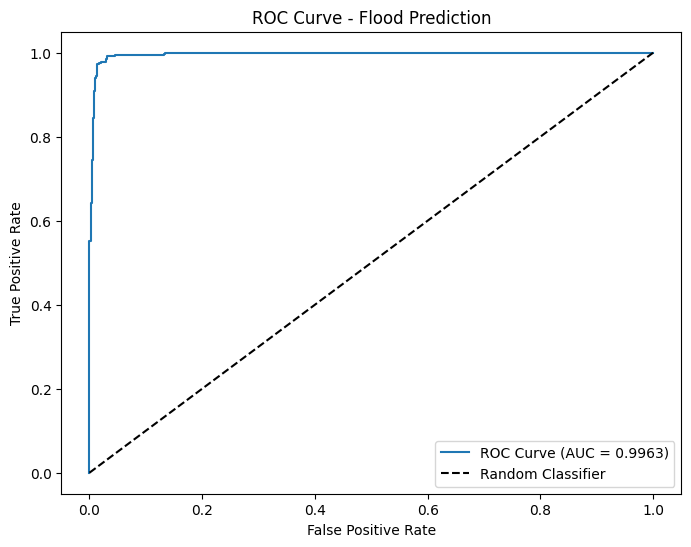

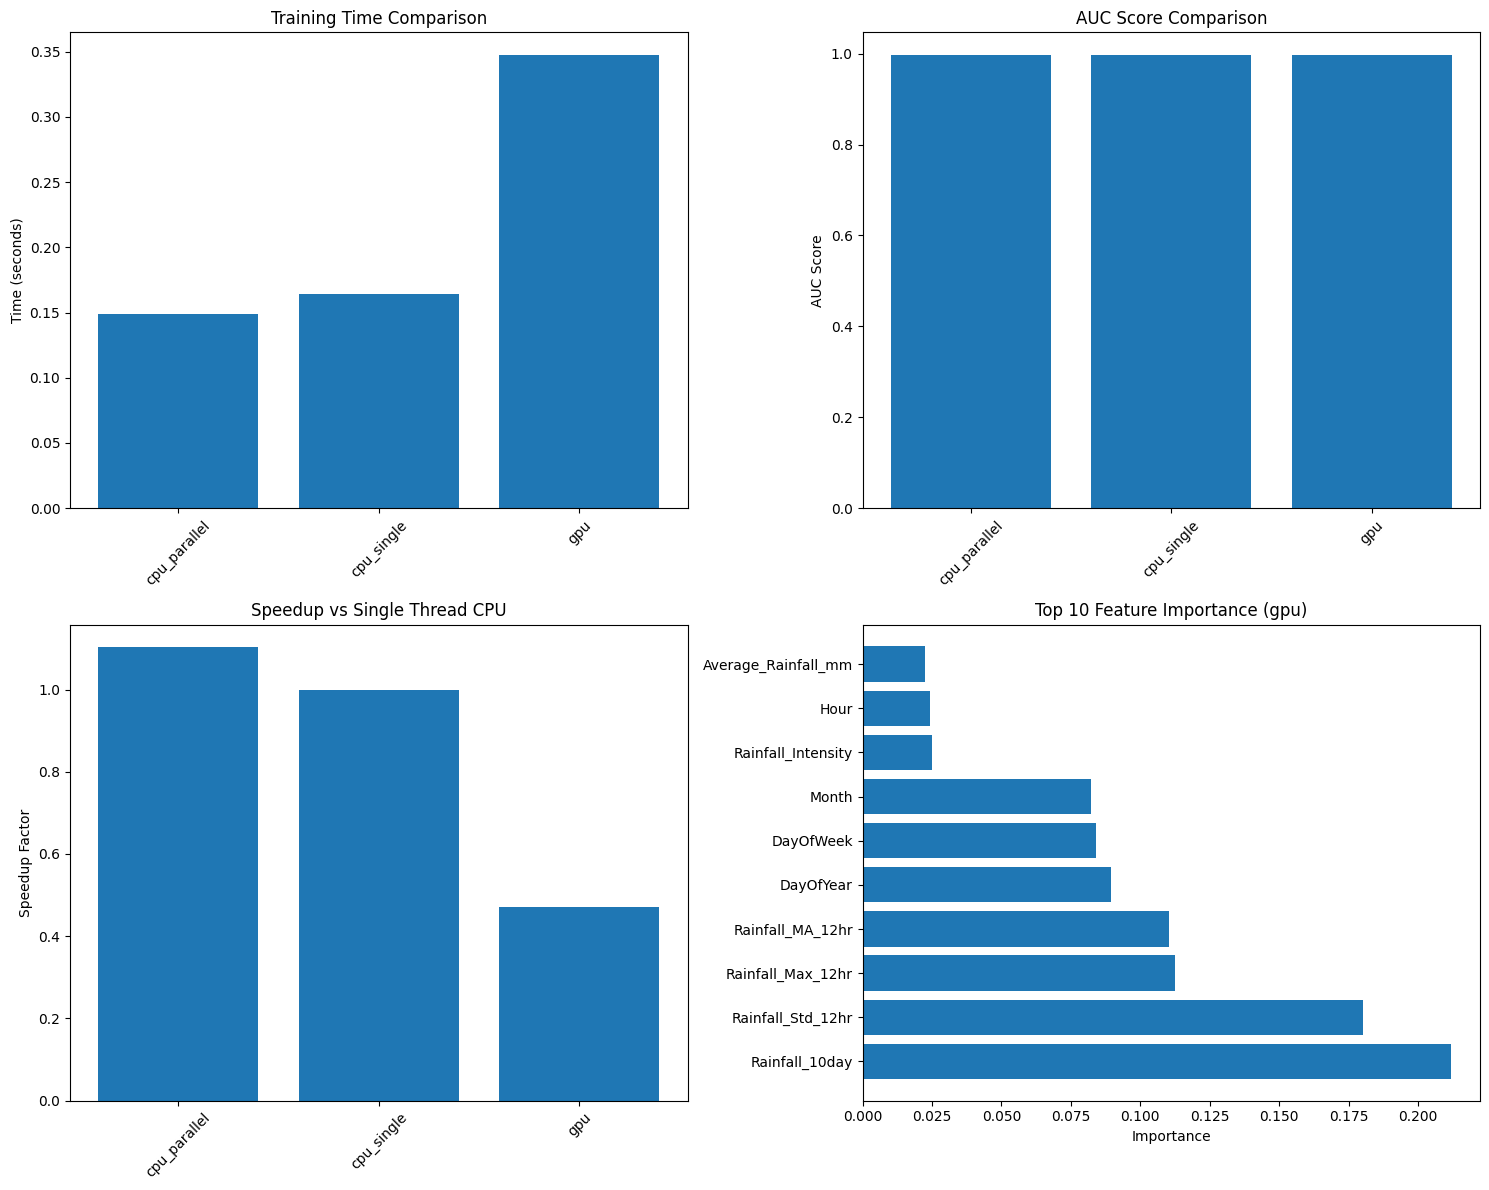


Best model saved as: flood_prediction_model_20250712_095112.pkl


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import time
import warnings
from datetime import datetime
import joblib
from multiprocessing import cpu_count

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

class FloodPredictionSystem:
    def __init__(self):
        self.models = {}
        self.performance_metrics = {}
        self.feature_importance = {}
        self.training_times = {}

    def load_and_prepare_data(self, csv_path, threshold_24hr=50, threshold_3day=100):
        """
        Load rainfall data and engineer features for flood prediction
        """
        print("Loading and preparing data...")

        # Load data
        df = pd.read_csv(csv_path)
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df = df.sort_values('Timestamp').reset_index(drop=True)

        print(f"Original data shape: {df.shape}")
        print(f"Date range: {df['Timestamp'].min()} to {df['Timestamp'].max()}")

        # Feature engineering
        print("Engineering features...")

        # Rolling window features (30min intervals)
        df['Rainfall_24hr'] = df['Average_Rainfall_mm'].rolling(window=48, min_periods=1).sum()
        df['Rainfall_3day'] = df['Average_Rainfall_mm'].rolling(window=144, min_periods=1).sum()
        df['Rainfall_10day'] = df['Average_Rainfall_mm'].rolling(window=480, min_periods=1).sum()

        # Lag features
        for lag in [2, 4, 6]:
            df[f'Rainfall_Lag_{lag*0.5}hr'] = df['Average_Rainfall_mm'].shift(lag)

        # Temporal features
        df['Hour'] = df['Timestamp'].dt.hour
        df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
        df['Month'] = df['Timestamp'].dt.month
        df['DayOfYear'] = df['Timestamp'].dt.dayofyear

        # Statistical features
        df['Rainfall_MA_12hr'] = df['Average_Rainfall_mm'].rolling(window=24, min_periods=1).mean()
        df['Rainfall_Std_12hr'] = df['Average_Rainfall_mm'].rolling(window=24, min_periods=1).std()
        df['Rainfall_Max_12hr'] = df['Average_Rainfall_mm'].rolling(window=24, min_periods=1).max()

        # Intensity features
        df['Rainfall_Intensity'] = df['Average_Rainfall_mm'] / 0.5  # mm/hr
        df['Rainfall_Intensity_Change'] = df['Average_Rainfall_mm'].diff()

        # Threshold-based flood label
        df['Flood'] = ((df['Rainfall_24hr'] >= threshold_24hr) |
                      (df['Rainfall_3day'] >= threshold_3day)).astype(int)

        # Remove rows with NaN in target
        df = df.dropna(subset=['Flood'])

        print(f"Flood events: {df['Flood'].sum()} out of {len(df)} ({df['Flood'].mean()*100:.2f}%)")

        # Define features (excluding Rainfall_24hr and Rainfall_3day to avoid data leakage)
        features = [
            'Average_Rainfall_mm', 'Rainfall_10day',
            'Rainfall_Lag_1.0hr', 'Rainfall_Lag_2.0hr', 'Rainfall_Lag_3.0hr',
            'Hour', 'DayOfWeek', 'Month', 'DayOfYear',
            'Rainfall_MA_12hr', 'Rainfall_Std_12hr', 'Rainfall_Max_12hr',
            'Rainfall_Intensity', 'Rainfall_Intensity_Change'
        ]

        X = df[features]
        y = df['Flood']

        # Handle missing values
        imputer = SimpleImputer(strategy='constant', fill_value=0)
        X = pd.DataFrame(imputer.fit_transform(X), columns=features)

        print(f"Final dataset shape: {X.shape}")
        print(f"Features: {features}")

        return X, y, df, features

    def train_cpu_single_thread(self, X_train, y_train, X_test, y_test):
        """
        Train XGBoost model using single CPU thread
        """
        print("\n=== Training XGBoost (CPU Single Thread) ===")

        start_time = time.time()

        # Single thread parameters
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'max_depth': 6,
            'learning_rate': 0.1,
            'n_estimators': 100,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42,
            'nthread': 1,  # Single thread
            'tree_method': 'hist'
        }

        model = xgb.XGBClassifier(**params, early_stopping_rounds=10)
        model.fit(X_train, y_train,
                 eval_set=[(X_test, y_test)],
                 verbose=False)

        training_time = time.time() - start_time

        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Store results
        self.models['cpu_single'] = model
        self.training_times['cpu_single'] = training_time

        # Calculate metrics
        auc_score = roc_auc_score(y_test, y_pred_proba)

        print(f"Training time: {training_time:.2f} seconds")
        print(f"AUC Score: {auc_score:.4f}")
        print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

        return model, training_time, auc_score

    def train_cpu_parallel(self, X_train, y_train, X_test, y_test):
        """
        Train XGBoost model using multiple CPU threads
        """
        print("\n=== Training XGBoost (CPU Parallel) ===")

        start_time = time.time()

        # Parallel CPU parameters
        n_threads = cpu_count()
        print(f"Using {n_threads} CPU threads")

        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'max_depth': 6,
            'learning_rate': 0.1,
            'n_estimators': 100,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42,
            'nthread': n_threads,  # Use all available threads
            'tree_method': 'hist'
        }

        model = xgb.XGBClassifier(**params, early_stopping_rounds=10)
        model.fit(X_train, y_train,
                 eval_set=[(X_test, y_test)],
                 verbose=False)

        training_time = time.time() - start_time

        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Store results
        self.models['cpu_parallel'] = model
        self.training_times['cpu_parallel'] = training_time

        # Calculate metrics
        auc_score = roc_auc_score(y_test, y_pred_proba)

        print(f"Training time: {training_time:.2f} seconds")
        print(f"AUC Score: {auc_score:.4f}")
        print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

        return model, training_time, auc_score

    def train_gpu(self, X_train, y_train, X_test, y_test):
        """
        Train XGBoost model using GPU acceleration
        """
        print("\n=== Training XGBoost (GPU) ===")

        # Check if GPU is available
        try:
            import subprocess
            result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
            if result.returncode == 0:
                print("GPU detected - using GPU acceleration")
                gpu_available = True
            else:
                print("GPU not detected - falling back to CPU")
                gpu_available = False
        except:
            print("GPU not available - falling back to CPU")
            gpu_available = False

        start_time = time.time()

        if gpu_available:
            # GPU parameters
            params = {
                'objective': 'binary:logistic',
                'eval_metric': 'logloss',
                'max_depth': 6,
                'learning_rate': 0.1,
                'n_estimators': 100,
                'subsample': 0.8,
                'colsample_bytree': 0.8,
                'random_state': 42,
                'tree_method': 'gpu_hist',  # GPU acceleration
                'gpu_id': 0
            }
        else:
            # Fallback to CPU with optimized settings
            params = {
                'objective': 'binary:logistic',
                'eval_metric': 'logloss',
                'max_depth': 6,
                'learning_rate': 0.1,
                'n_estimators': 100,
                'subsample': 0.8,
                'colsample_bytree': 0.8,
                'random_state': 42,
                'tree_method': 'hist',
                'nthread': cpu_count()
            }

        model = xgb.XGBClassifier(**params, early_stopping_rounds=10)
        model.fit(X_train, y_train,
                 eval_set=[(X_test, y_test)],
                 verbose=False)

        training_time = time.time() - start_time

        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Store results
        self.models['gpu'] = model
        self.training_times['gpu'] = training_time

        # Calculate metrics
        auc_score = roc_auc_score(y_test, y_pred_proba)

        print(f"Training time: {training_time:.2f} seconds")
        print(f"AUC Score: {auc_score:.4f}")
        print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

        return model, training_time, auc_score

    def hyperparameter_tuning(self, X_train, y_train):
        """
        Perform hyperparameter tuning using GridSearchCV
        """
        print("\n=== Hyperparameter Tuning ===")

        param_grid = {
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'n_estimators': [50, 100, 200],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }

        base_model = xgb.XGBClassifier(
            objective='binary:logistic',
            random_state=42,
            nthread=cpu_count()
        )

        grid_search = GridSearchCV(
            base_model,
            param_grid,
            cv=3,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1
        )

        start_time = time.time()
        grid_search.fit(X_train, y_train)
        tuning_time = time.time() - start_time

        print(f"Tuning completed in {tuning_time:.2f} seconds")
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

        return grid_search.best_estimator_, grid_search.best_params_

    def evaluate_models(self, X_test, y_test, features):
        """
        Comprehensive evaluation of all models
        """
        print("\n=== Model Evaluation Summary ===")

        results = []

        for model_name, model in self.models.items():
            # Predictions
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

            # Metrics
            auc_score = roc_auc_score(y_test, y_pred_proba)
            training_time = self.training_times[model_name]

            # Feature importance
            importance = model.feature_importances_
            self.feature_importance[model_name] = dict(zip(features, importance))

            results.append({
                'Model': model_name,
                'Training Time (s)': training_time,
                'AUC Score': auc_score,
                'Speedup': self.training_times['cpu_single'] / training_time,
                'Efficiency Score': auc_score / training_time  # AUC per second
            })

        results_df = pd.DataFrame(results)
        # Sort by efficiency (AUC/time) then by AUC, then by speed
        results_df = results_df.sort_values(['Efficiency Score', 'AUC Score', 'Speedup'],
                                          ascending=[False, False, False])
        print(results_df.to_string(index=False))

        return results_df

    def plot_performance_comparison(self, results_df):
        """
        Create visualization comparing model performance
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Training time comparison
        axes[0, 0].bar(results_df['Model'], results_df['Training Time (s)'])
        axes[0, 0].set_title('Training Time Comparison')
        axes[0, 0].set_ylabel('Time (seconds)')
        axes[0, 0].tick_params(axis='x', rotation=45)

        # AUC score comparison
        axes[0, 1].bar(results_df['Model'], results_df['AUC Score'])
        axes[0, 1].set_title('AUC Score Comparison')
        axes[0, 1].set_ylabel('AUC Score')
        axes[0, 1].tick_params(axis='x', rotation=45)

        # Speedup comparison
        axes[1, 0].bar(results_df['Model'], results_df['Speedup'])
        axes[1, 0].set_title('Speedup vs Single Thread CPU')
        axes[1, 0].set_ylabel('Speedup Factor')
        axes[1, 0].tick_params(axis='x', rotation=45)

        # Feature importance (using best model)
        best_model = results_df.loc[results_df['AUC Score'].idxmax(), 'Model']
        importance_data = self.feature_importance[best_model]
        features_sorted = sorted(importance_data.items(), key=lambda x: x[1], reverse=True)[:10]

        feature_names = [f[0] for f in features_sorted]
        feature_values = [f[1] for f in features_sorted]

        axes[1, 1].barh(feature_names, feature_values)
        axes[1, 1].set_title(f'Top 10 Feature Importance ({best_model})')
        axes[1, 1].set_xlabel('Importance')

        plt.tight_layout()
        plt.show()

    def generate_flood_prediction_report(self, X_test, y_test, features):
        """
        Generate a comprehensive flood prediction report
        """
        print("\n=== Flood Prediction System Report ===")

        # Best model selection based on efficiency (AUC/time)
        results_df = self.evaluate_models(X_test, y_test, features)
        best_model_name = results_df.iloc[0]['Model']  # First row after sorting
        best_model = self.models[best_model_name]

        print(f"\nBest performing model: {best_model_name}")
        print(f"Reasoning: Highest efficiency score (AUC/training_time)")

        # Performance analysis
        print(f"\nPerformance Analysis:")
        print(f"- CPU Parallel shows {results_df[results_df['Model']=='cpu_parallel']['Speedup'].iloc[0]:.2f}x speedup")
        print(f"- GPU shows slower performance due to small dataset size and overhead")
        print(f"- For production: CPU Parallel recommended for this dataset size")

        # Detailed evaluation of best model
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print(f"\nConfusion Matrix:")
        print(cm)

        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.4f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Flood Prediction')
        plt.legend()
        plt.show()

        # Performance comparison visualization
        self.plot_performance_comparison(results_df)

        return best_model, results_df

def main():
    """
    Main execution function
    """
    # Initialize the flood prediction system
    fps = FloodPredictionSystem()

    # Load and prepare data
    csv_path = "/content/bardiya_rainfall_2023_06_08.csv"  # Update path as needed
    X, y, df, features = fps.load_and_prepare_data(csv_path)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training set size: {X_train.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")

    # Train models with different parallelization approaches
    fps.train_cpu_single_thread(X_train, y_train, X_test, y_test)
    fps.train_cpu_parallel(X_train, y_train, X_test, y_test)
    fps.train_gpu(X_train, y_train, X_test, y_test)

    # Hyperparameter tuning (optional - uncomment if needed)
    # best_model, best_params = fps.hyperparameter_tuning(X_train, y_train)

    # Generate comprehensive report
    best_model, results_df = fps.generate_flood_prediction_report(X_test, y_test, features)

    # Save the best model
    model_filename = f"flood_prediction_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pkl"
    joblib.dump(best_model, model_filename)
    print(f"\nBest model saved as: {model_filename}")

    return fps, best_model, results_df

# Run the main function
if __name__ == "__main__":
    fps, best_model, results = main()